### Asunto-osakeyhtiön asuntojen lämmitykseen käytetty energiankulutus. Lineaarisen regression avulla haettu yhtälö 

Rakennusten lämmitys on lineaarisesti riippuvainen ulkolämpötilasta. Tämä riippuvuus voidaan kuvata yhtälöllä y=ax+b, missä a≠0. Sklearnilla a ja b voidaan selvittää, jolloin yhtälö on valmis. Tässä harjoituksessa selvitetään yhtälö yhden As Oy:n osalta. Yhtälön selvittämiseen tarvitaan seuraavia datoja: Taloyhtiön lämmitykseen käyttämä energiankulutus, ulkolämpötila ja vedenkulutus sikäli kun käyttövesi lämmitetään samalla energialähteellä kuin rakennukset. Kulutustiedot poimitaan Afry Oy:n websivustolta. Lämpötilatiedot puolestaan haetaan Ilmatieteenlaitoksen sivustolta. 

In [154]:
import numpy as np
import pandas as pd

#Mallinnuksessa käytetään sklearna, joten tuodaan sen vaatimat modulit.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [155]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Käytetään dataa, joka on poimittu Afry Oy:n tarjoaman rajapinnan kautta. 

In [156]:
df = pd.read_excel('Data.xlsx') #Tuodaan kulutustiedot"
df_temp = pd.read_excel('C.xlsx') #Tuodaan lämpötilatiedot 
df_temp['DS'] = pd.to_datetime(df_temp['DS']) 

df_C = pd.merge(df,df_temp, on='DS',how='inner') #Yhdistetään dataframet.
df_C.replace(r'^-$', np.nan, regex=True, inplace=True) #muuttaa ne solut, joissa NULL arvo on merkitty merkillä '.' arvoksi NaN.


In [157]:
# Katsotaan vielä miltä data näyttää
print(df_C.describe())

                                  DS           MWh            M3  \
count                          41108  41108.000000  41108.000000   
mean   2021-09-26 20:12:00.998345984      0.015255      0.178394   
min              2019-05-23 00:00:00      0.000000      0.000000   
25%              2020-07-24 20:45:00      0.005392      0.070000   
50%              2021-09-27 10:30:00      0.015105      0.150000   
75%              2022-11-29 12:15:00      0.022945      0.260000   
max              2024-01-31 23:00:00      0.064635      1.230000   
std                              NaN      0.010747      0.137911   

                  C          wind           hPa        moist%        Wperm2  
count  41084.000000  41081.000000  41087.000000  40846.000000  40229.000000  
mean       6.848041      4.333726   1011.339382     79.016452    113.102913  
min      -26.000000      0.200000    961.700000     17.000000     -9.800000  
25%        0.300000      2.800000   1004.400000     67.000000     -1.100000

On yllättävää havaita, että energiankulutus saa myös nolla-arvoja. Tuon ei pitäisi olla mahdollista, koska veden kiertäessä putkistossa tapahtuu aina lämpöhäviöitä vaikka ulkolämpötila olisi raja-arvon yläpuolella ja vedenkulutus olisi nolla. 

Katsotaan siis miltä data näyttää. Tulostetaan aluksi hajontakuvio. (Scatterplot)

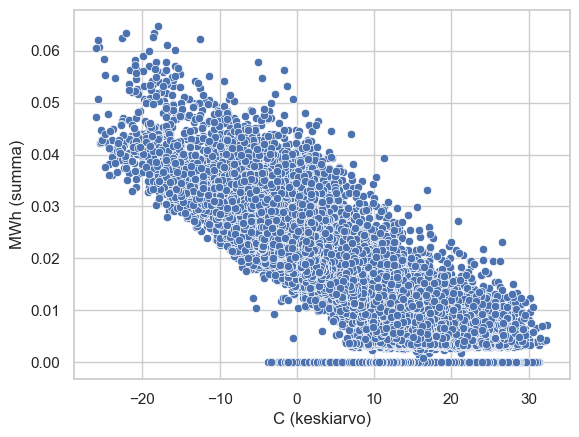

In [158]:
# Aseta Seaborn-tyyli
sns.set(style="whitegrid")

# Luodaan pistekaavio
sns.scatterplot(x="C", y="MWh", data=df_C)

# Määrittele x- ja y-akseleiden otsikot
plt.xlabel('C (keskiarvo)')
plt.ylabel('MWh (summa)')

# Näytä kaavio
plt.show()

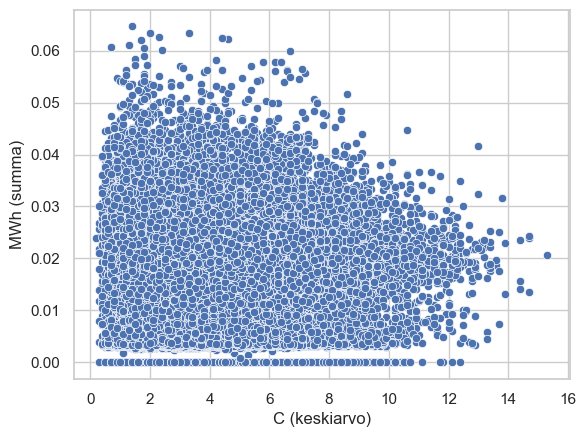

In [159]:
# Aseta Seaborn-tyyli
sns.set(style="whitegrid")

# Luodaan pistekaavio
sns.scatterplot(x="wind", y="MWh", data=df_C)

# Määrittele x- ja y-akseleiden otsikot
plt.xlabel('C (keskiarvo)')
plt.ylabel('MWh (summa)')

# Näytä kaavio
plt.show()

Tuulen vaikutus ei näyttäisi olevan lainkaan niin selkeästi lineaarinen kuin ulkolämpötilan. Pidetään se kuitenkin vielä mukana laskennassa. Sillä näyttäisi kuitenkin olevan lievästi positiivinen vaikutus, kuten seuraavasta korrelaatiomatriisista voidaan päätellä.

Tarkastellaan vielä korrelaatioita.

<Axes: >

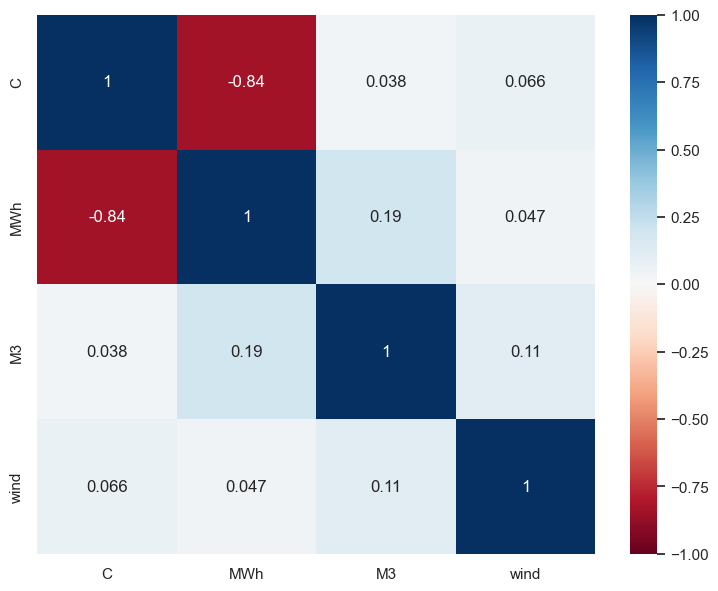

In [160]:
df_corr = df_C[['C','MWh','M3','wind']]

corr_matrix = df_corr.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix,vmin=-1.0,vmax=1.0, cmap='RdBu', annot=True)

Kuten kuvaajista näkyy, on energiankulutus joillakin riveillä todella nolla, joka käytännössä ei ole oikein mahdollista. Tarkastellaan vielä miltä jakauma näyttää histogrammissa. Sinänsä hajontakuvio näyttäisi siltä, että lineaarisuus on selkeä, mutta arvot hajaantuvat voimakkaasti. Tämä puolestaan johtuu siitä, että eenrgiaa käytetään myös veden lämmitukseen ja vedenkulutus vaihtelee voimakkaasti ajallisesti ja määrällisesti.

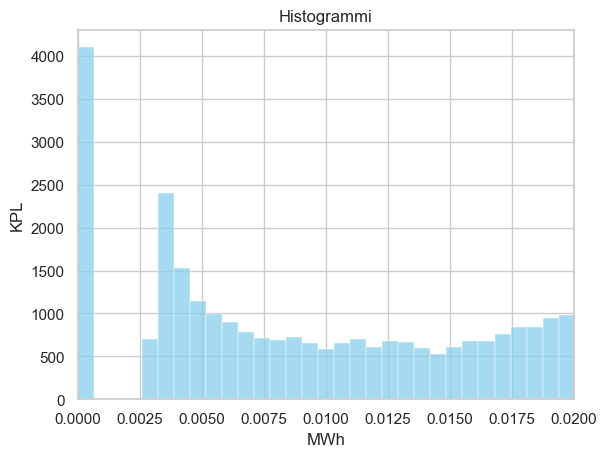

In [161]:
sns.set(style="whitegrid")

# Piirretään histogrammi
sns.histplot(df_C['MWh'], kde=False, color="skyblue", bins=100)
plt.xlim(0, 0.02)
# Lisätään otsikko ja akselien nimet
plt.title('Histogrammi')
plt.xlabel('MWh')
plt.ylabel('KPL')

# Näytetään kuva
plt.show()

Histogrammin avulla voimme päätellä, että lämpöhäviöt ovat ehkä n. 0.0025 MW/h eli n. 25 KW/h. Tämä voidaan vielä varmistaa/tarkentaa, jahka saamme ensin laskettua asuntojen lämmittämisen yhtälön.

Jotta saamme laskettua paljonko rakennusten lämmittäminen vie energiaa ulkolämpötilan funktiona, on energian kulutuksesta pystyttävä erottelemaan sekä veden lämmittämiseen kuluva energia, että lämpöhäviöiden osuus. Jos datasta löytyy sellaisia rivejä, jolloin vettä ei käytetä, tai käytetään vain kylmää vettä ja nuo rivit poistetaan, niin silloin saamme laskettua rakennuksen lämmittämisen vaativan energian.

Poistetaan kuitenkin alkajaisiksi virhelähteet eli ne rivit, joissa energian kulutus on alle 0.0025 MWh.

In [162]:
# Poistetaan rivit, joissa MWh saa arvon alle 0.0025 MWH / h joka tarkoittaa, että poistetaan n. 10% aineistosta
dfMWH0025 = df_C[df_C["MWh"] > 0.0025]
dfMWH0025.count()
#null_rivit = dfMWH0[dfMWH0.isnull().any(axis=1)]
#null_rivit.head(50)

DS        36999
MWh       36999
M3        36999
C         36975
wind      36972
hPa       36978
moist%    36777
Wperm2    36978
dtype: int64

Kaikissa sarakkeissa ei ilmeisesti ole lämpötilan ja tuulen arvoja. Koska niitä on selkeästi vähän, niin poistetaan ne.

In [163]:
dfMWH0 = dfMWH0025.dropna()

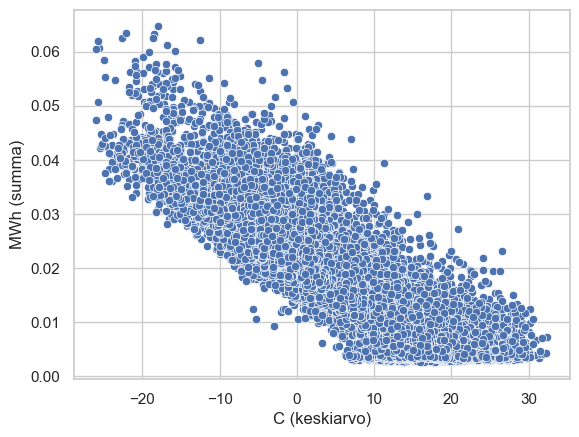

In [164]:
# Aseta Seaborn-tyyli
sns.set(style="whitegrid")

# Luodaan pistekaavio
sns.scatterplot(x="C", y="MWh", data=dfMWH0)

# Määrittele x- ja y-akseleiden otsikot
plt.xlabel('C (keskiarvo)')
plt.ylabel('MWh (summa)')

# Näytä kaavio
plt.show()

Jotta saamme selville minkälainen yhtälö rakennuksen lämmittämiselle syntyy, on poistettava veden lämmitykseen käytettävä
energia sekä lämpöhäviöiden viemä energia.
Aloitetaan niin, että poistetaan aineistosta ne rivit, joissa vedenkulutus on maksimissaan 0.02 l/t. Käytetään 0.02 l/t siksi, että WC:n huuhtelussa kuluu kylmää vettä n. 10 l kerrallaan. Voisimme tietysti poistaa kaikki rivit, jossa veden kulutus ylittää arvon 0, mutta näin saadaan pidettyä aineiston määrä hieman suurempana, joka on aina parempi.
Tällöin jäljelle jää vain asuntojen lämmityksen viemä energia ja lämpöhäviöiden osuus.

In [165]:
dfAs = dfMWH0[dfMWH0["M3"] <= 0.02]
dfAs.describe()


,DS,MWh,M3,C,wind,hPa,moist%,Wperm2
count,4211,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000
mean,2021-07-15 02:12:43.429114112,0.013761,0.012322,5.152957,3.739017,1011.461458,86.860603,3.489955
min,2019-05-23 00:00:00,0.002513,0.000000,-24.800000,0.300000,965.700000,36.000000,-9.000000
25%,2020-03-24 14:30:00,0.005334,0.010000,0.100000,2.300000,1004.600000,81.000000,-2.000000
50%,2021-03-15 02:00:00,0.013607,0.010000,4.700000,3.500000,1012.600000,91.000000,-1.300000
75%,2022-10-18 01:30:00,0.019675,0.020000,11.900000,4.800000,1019.200000,97.000000,-0.700000
max,2024-01-31 04:00:00,0.053119,0.020000,29.900000,12.500000,1043.500000,100.000000,830.400000
std,NaN,0.008509,0.007338,8.165805,1.989753,11.453821,12.609324,45.424338


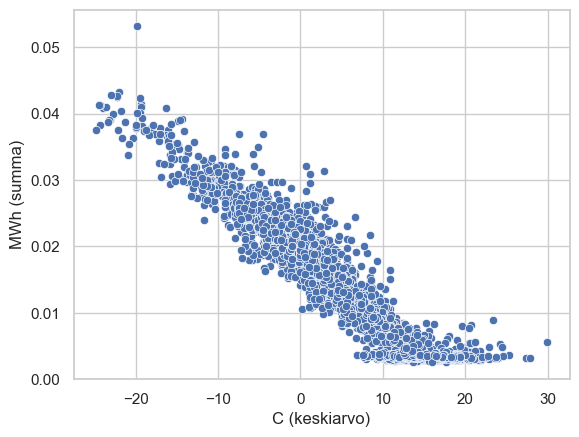

In [166]:
#Katsotaan vielä miltä hajontakuvio näyttää
sns.set(style="whitegrid")

# Luodaan pistekaavio
sns.scatterplot(x="C", y="MWh",  data=dfAs)

# Määrittele x- ja y-akseleiden otsikot
plt.xlabel('C (keskiarvo)')
plt.ylabel('MWh (summa)')

# Näytä kaavio
plt.show()

In [167]:
# Aiemmin päädyimme siihen, että lämpöhäviöiden osuus energiankulutuksesta on 0.025 MW/h. Vähennetään tämä sarakkeesta MWh
dfAs_2 = dfAs.copy()

# lasketaan vain lämmitysenergia 
dfAs_2['MWh_025'] = dfAs_2['MWh']-0.0025
dfAs_2 = dfAs_2.drop('MWh',axis=1)
# Katsotaan, vielä, ettei MWh mene alle nollan.
dfAs_2.describe()


,DS,M3,C,wind,hPa,moist%,Wperm2,MWh_025
count,4211,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000
mean,2021-07-15 02:12:43.429114112,0.012322,5.152957,3.739017,1011.461458,86.860603,3.489955,0.011261
min,2019-05-23 00:00:00,0.000000,-24.800000,0.300000,965.700000,36.000000,-9.000000,0.000013
25%,2020-03-24 14:30:00,0.010000,0.100000,2.300000,1004.600000,81.000000,-2.000000,0.002834
50%,2021-03-15 02:00:00,0.010000,4.700000,3.500000,1012.600000,91.000000,-1.300000,0.011107
75%,2022-10-18 01:30:00,0.020000,11.900000,4.800000,1019.200000,97.000000,-0.700000,0.017175
max,2024-01-31 04:00:00,0.020000,29.900000,12.500000,1043.500000,100.000000,830.400000,0.050619
std,NaN,0.007338,8.165805,1.989753,11.453821,12.609324,45.424338,0.008509


Hyvältä näyttää.

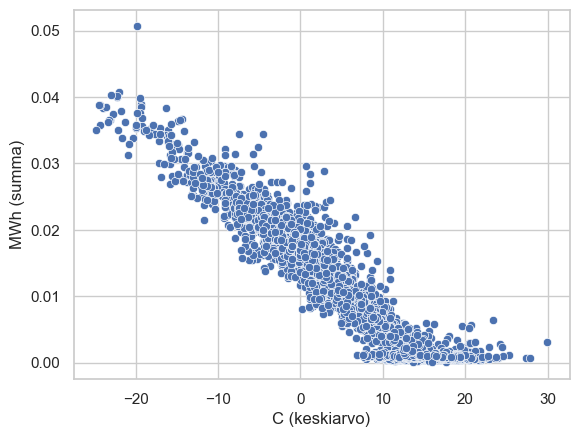

In [168]:
#Katsotaan vielä miltä hajontakuvio näyttää
sns.set(style="whitegrid")

# Luodaan pistekaavio
sns.scatterplot(x="C", y="MWh_025",  data=dfAs_2)

# Määrittele x- ja y-akseleiden otsikot
plt.xlabel('C (keskiarvo)')
plt.ylabel('MWh (summa)')

# Näytä kaavio
plt.show()

Seuraavaksi jaetaan muuttujat selittäviin ja vastemuuttujaan

In [169]:
# Selittävät muuttujat
x = dfAs_2[['C','wind']]
# Selitettävä muuttuja
y = dfAs_2['MWh_025']

Jaetaan aineisto koulutusdataan ja testidataan

In [170]:
# jaetaan aineisto koulutus- ja testidataan. Käytetään 70/30 jakoa.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3) 
np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test)

((2947, 2), (1264, 2), (2947,), (1264,))

Ajetaan mallin sovitus.

In [171]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

Etsitään muuttujien kerroimet sekä leikkauspiste

In [172]:
coef =pd.DataFrame(model.coef_, x_train.columns, columns = ['Coefficients'])
coef['Coefficients'].sort_values()
leikkauspiste = model.intercept_
rajalampo = -leikkauspiste/coef['Coefficients'][0] # tämä toteutuu kun y saa arvon 0. Käytetään lisäksi x2:lle arvoa 0 (tuulen kerroin)
print(f"Rakennuksen lämmityksen yhtälö on siten seuraava: y = {coef['Coefficients'][0]:.6f}x1 + {coef['Coefficients'][1]:.6f}x2 + {leikkauspiste:.6f}")
print(f"Käytännössä tämä tarkoittaa sitä, että rakennuksen lämmittämiseen ei käytetä energiaa kun ulkolämpötila ylittää {rajalampo:.1f} astetta.")

Rakennuksen lämmityksen yhtälö on siten seuraava: y = -0.000990x1 + 0.000435x2 + 0.014729
Käytännössä tämä tarkoittaa sitä, että rakennuksen lämmittämiseen ei käytetä energiaa kun ulkolämpötila ylittää 14.9 astetta.


### Testataan mallin toimivuus

Regressiomallin toimivuutta arvioitaessa voidaan käyttää residuaaleja. Niille pätevät seuraavat yleisesti säännöt:

1) Nolla-keskiarvo: Residuaalien keskiarvon tulisi lähestyä nollaa. Tämä tarkoittaa, että malli ei yleisesti yli- tai aliarvioi riippuvaa muuttujaa.

2) Normaalius: Residuaalien tulisi noudattaa normaalijakaumaa. Tämä tarkoittaa sitä, että suurin osa residuaaleista sijoittuu nollan ympärille, ja niiden hajonta on symmetrinen.

3) Satunnaisuus: Residuaalien tulisi olla satunnaisesti hajautettuja ympäri nollaa. Tämä tarkoittaa sitä, että ei tulisi olla selkeää kuvioita residuaalien hajonnassa tietyissä ennustearvojen väleissä.

4) Varianssin vakaus: Residuaalien hajonnan pitäisi pysyä suhteellisen vakiona ennustettujen arvojen yli. Tätä kutsutaan homoskedastisuudeksi. Epävakaa hajonta voi viitata siihen, että malli ei pysty selittämään kaikkea tietoa tai että jotkin ennustajamuuttujat eivät ole sopivia.

5) Ei-autokorrelaatio: Residuaalien ei tulisi näyttää mitään järjestelmällistä kaavaa tai mallia, mikä viittaisi niihin liittyvään aikasarja-autokorrelaatioon. Tämä tarkoittaa sitä, että aikasarjaan liittyvät havainnot eivät ole toistensa kanssa korreloivia. (tässä ei testata aikasarjakorrelaatiota, vaikka aikasarjasta onkin kyse.)

In [173]:
#Luodaan ennuste käyttämällä laskentaan ulkolämpötilan ja tuulen testiarvoja
y_pred= pd.DataFrame(model.predict(x_test))

#Jotta saadaan laskettua residuaalit niin määritellään y_pred indeksi samaksi kuin y_test.
y_pred['index'] = x_test.index
y_pred.set_index('index', inplace=True, drop=True)




Testataan residuaalien keskiarvo (1) ja jakauma (2)

Jäännosarvojen keskiarvo (0.00003)


<Axes: >

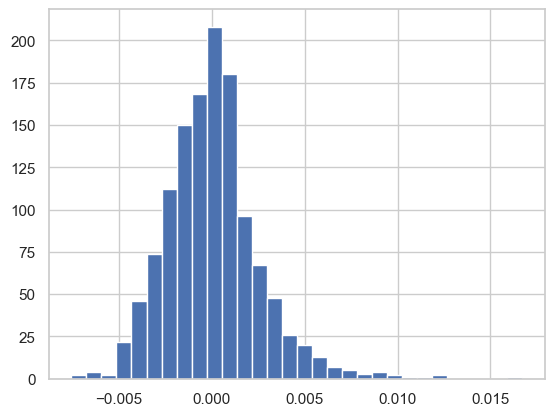

In [174]:
# Lasketaan testiaineistolle jäännösarvot.
residuals = pd.DataFrame(data = y_test)['MWh_025']-y_pred[0] #'MWH' ja ovat sarakeotsikoita 
# Katsotaan miten residuaalit käyttäytyvät.
print(f"Jäännosarvojen keskiarvo ({residuals.mean():.5f})")
residuals.hist(bins=30)

Jäännösarvojen keskiarvo on hyvin lähellä nollaa. OK
Jäännnösarvojen jakauma näyttää muistuttavan normaalijakaumaa. Suoritetaan kuitenkin vielä Shapiro-Wilkinin testi, jolla normaalijakauma voidaan testata.

In [175]:
from scipy.stats import shapiro

# Suorita Shapiro-Wilkinin testi
stat, p_value = shapiro(residuals)

# Tulosta testin tulos
print("Testisuure:", stat)
print("p-arvo:", p_value)

# Tulkinta p-arvon perusteella
alpha = 0.05
if p_value > alpha:
    print("Data näyttää normaalijakautuneelta (hyväksytään nollahypoteesi)")
else:
    print("Data ei näytä normaalijakautuneelta (hylätään nollahypoteesi)")


Testisuure: 0.956537176768174
p-arvo: 6.232126108066335e-19
Data ei näytä normaalijakautuneelta (hylätään nollahypoteesi)


Shapiro-Wilkinin testin mukaan residuaalit eivät kuitenkaan olisi normaalijakautuneita, joka on yllättävää siksi, että visuaalisesti tarkastellen se näyttää siltä.

3) Tarkastetaan näyttävätkö residuaalit jakautuvan tasaisesti indeksin numeroavaruuteen hajontakuviossa. Jos näin on, niin se  viittaa yleensä siihen, että residuaalien varianssi on suhteellisen vakaa.

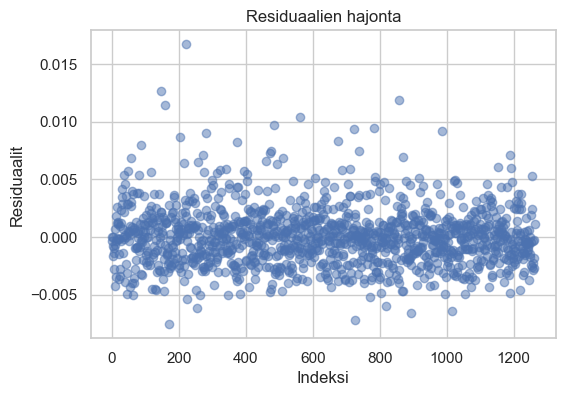

In [176]:
indeksi = range(len(residuals))
arvot = residuals
# Luo hajontakuvio
plt.figure(figsize=(6, 4))  # Aseta kuvion koko tarvittaessa
plt.scatter(indeksi, arvot, alpha=0.5)  # alpha-parametri säätelee pisteen läpinäkyvyyttä

# Aseta otsikko ja nimet akselit
plt.title('Residuaalien hajonta')
plt.xlabel('Indeksi')
plt.ylabel('Residuaalit')

# Näytä hajontakuvio
plt.show()

Testi näyttäisi residuaaliennäyttävät jakaantuvan tasaisesti indeksin numeroavaruuden yli, joten tämäkin on OK.

Katsotaan vielä miten residuaalit käyttäytyvät hajontakuviossa. 4)

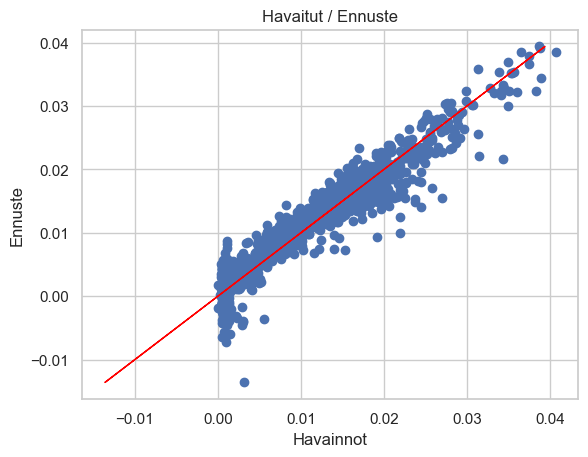

In [184]:
df2 = pd.DataFrame({'havainnot': y_test, 'ennuste': y_pred[0]})

plt.figure()
plt.scatter(x=y_test, y=y_pred)
plt.plot(y_pred, y_pred, color='red', linewidth=1)  # Lisätään viiva ennustettujen ja havaittujen arvojen väliin
plt.xlabel('Havainnot')
plt.ylabel('Ennuste')
plt.title('Havaitut / Ennuste')
plt.show()

Yllä olevassa hajontakuviossa ala-arvoilla hajonta on ehkä hieman suurempaa kuin muilla arvoilla, joskaan ei merkittävästi, joten siinä mielessä tulos on OK.

Lopuksi lasketaan Lasketaan vielä MSE ja R2

In [178]:
mse = mean_squared_error(pd.DataFrame(data = y_test)['MWh_025'], y_pred[0])
r2s = r2_score(pd.DataFrame(data = y_test)["MWh_025"], y_pred[0]) 
print("MSE = ", mse)
print("R2s = ", r2s)
print()
print("MSE on erittäin pieni, jonka vuoksi voimme olla tyytyväisiä.")
print(f"Laskelman mukaan ulkolämpötilalla ja tuulen nopeudella voidaan selittää {r2s*100:.2f}% energiankulutuksesta")


MSE =  6.451962329629661e-06
R2s =  0.9124299925244304

MSE on erittäin pieni, jonka vuoksi voimme olla tyytyväisiä.
Laskelman mukaan ulkolämpötilalla ja tuulen nopeudella voidaan selittää 91.24% energiankulutuksesta


Oletettavasti korrelaatio lämpötilan ja energiankulutuksen välillä on erittäin vahva. Se saadaan myös todennettua.

<Axes: >

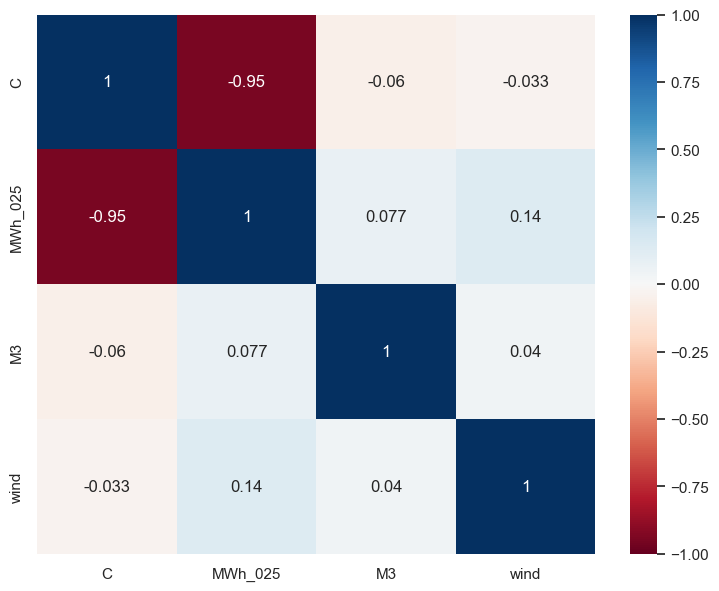

In [179]:
df_corr = dfAs_2[['C','MWh_025','M3','wind']]

corr_matrix = df_corr.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix,vmin=-1.0,vmax=1.0, cmap='RdBu', annot=True)

Tässä vaiheessa voimmekin sitten vielä varmistaa, että lämpöhäviöt todellakin ovat luokkaa 0.025 MWh. Poistetaan alkuperäisestä aineistosta virhedata (nolla energia), rivit, joissa ulkolämpötila ylittää arvon rajalämpötilan ja vedenkulutus alittaa 0.02 m3/h

In [180]:
dfAs_3 = df_C[((df_C["M3"] <= 0.02) & (df_C['C']>=rajalampo)) & (df_C['MWh']>=0.0015)]

waste = dfAs_3['MWh'].mean() # Lämpöhäviöiden keskiarvo
print(f"Tämän perusteella saamme itse asiassa tarkennettua lämpöhäviöiden määrän. Se on itse asiassa hieman alunperin arvioitua suurempi.")
print(f"Keskimäärin lämpöhäviöitä syntyy ({waste:.4f}) MW/h.")

Tämän perusteella saamme itse asiassa tarkennettua lämpöhäviöiden määrän. Se on itse asiassa hieman alunperin arvioitua suurempi.
Keskimäärin lämpöhäviöitä syntyy (0.0036) MW/h.


Tämän perusteella saamme itse asiassa tarkennettua lämpöhäviöiden määrän, joka on itse asiassa hieman alunperin arvioitua suurempi. Keskimäärin lämpöhäviöitä syntyy 0.35 MW/h.

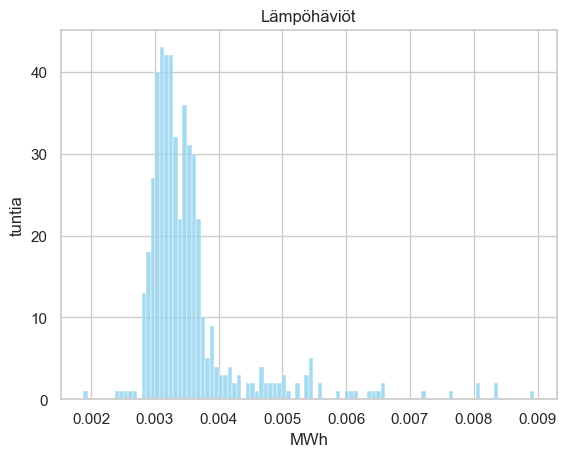

In [181]:
sns.set(style="whitegrid")

# Piirretään histogrammi
sns.histplot(dfAs_3['MWh'], kde=False, color="skyblue", bins=100)
# Lisätään otsikko ja akselien nimet
plt.title('Lämpöhäviöt')
plt.xlabel('MWh')
plt.ylabel('tuntia')

# Näytetään kuva
plt.show()

#### Lasketaan kuinka paljon kaukolämpökustannuksista olisi mahdollista säästää suljettaessa patteriverkoston kierto, jos lämpötila ylittää määritellyn rajalämmön.

In [182]:
# Kuukausihinnat ovat seuraavat:
Kuukausihinnat = {
    'kk': [1,2,3,4,5,6,7,8,9,10,11,12],
    'hinta':[82.36,82.36,51.29,51.29,31.47,26.25,26.25,26.25,32,51.83,62.55,82.36]}

df_hinnasto = pd.DataFrame(Kuukausihinnat)

In [183]:
#Poimitaan mukaan ne rivit, jolloin lämpötila ylittää rajalämmnön.
df_C = df_C[df_C["C"] >= rajalampo] 

# Lisätään uudet sarakkeet 'Year' ja 'kk, koska kaukolämpö hinnoitellaan kuukausittain.
df_C['Year'] = df_C['DS'].dt.year
df_C['kk'] = df_C['DS'].dt.month

#katsotaan mikä oli tilanne viime vuonna koska hinnasto oli viime vuoden hinnasto
vuosi = df_C[df_C['DS'].dt.year == 2023]['Year'].max()

# Lasketaan kuinka monta tuntia per kk viime oli vuonna sellaisia, jolloin lämpötila ylitti rajalämmön
df_count_per_month = df_C['kk'].value_counts().sort_index()

# Yhdisteään hinnasto ja rajalämmön ylittävät tuntimäärät
df_yhdistetty = pd.merge(df_hinnasto,df_count_per_month,on='kk')

# Luodaan uusi sarake 'Kustannus' kertomalla hinta, kulutus ja puolikas lämpöhukasta
df_yhdistetty['Säästö'] = df_yhdistetty['hinta'] * df_yhdistetty['count'] * waste/2

kokonaissäästö = df_yhdistetty['Säästö'].sum()
print(df_yhdistetty)
print()
print(f"Mikäli patteriverkoston kierto olisi sammutettu lämpötilan ylittäessa rajalämmön ({rajalampo:.1f}) Celcius-astetta olisi kokonaissäästö vuodelle {vuosi:.0f} ollut {kokonaissäästö:.2f} EUR")


   kk  hinta  count      Säästö
0   4  51.29     64    5.837124
1   5  31.47    571   31.953551
2   6  26.25   2431  113.475092
3   7  26.25   2689  125.518109
4   8  26.25   2566  119.776670
5   9  32.00    887   50.473088
6  10  51.83     24    2.211967

Mikäli patteriverkoston kierto olisi sammutettu lämpötilan ylittäessa rajalämmön (14.9) Celcius-astetta olisi kokonaissäästö vuodelle 2023 ollut 449.25 EUR
